# 모든 장르 간 편향성 측정해 보기

## 프로젝트 프로세스
1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. target, attribute 단어 셋 만들기
    - 이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 
    - 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 
    - 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.
    - TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 
    대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

4. WEAT score 계산과 시각화
    - 영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 
    - 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

## 평가지표
1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
    - 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
    - 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.
    - 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

## 코드 구현

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

Matplotlib is building the font cache; this may take a moment.


### 사전학습된 Word Embedding에 WEAT 적용

In [2]:
# 데이터와 모델 결로 설정
data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

In [3]:
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)
w2v

In [4]:
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['i']))           # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)       # 300 차원을 가지는 500000개 단어

500000
300
(500000, 300)


In [5]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [6]:
# 'happy'와 가장 유사한 단어
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [7]:
# 'familiy'라는 오타도 있음
# 데이터셋에 오타도 많이 등장하기때문에 오타 단어도 포함됨
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [8]:
# 코사인 유사도 계산함수
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

# 단어 w가 A와 B 집합 각각 가지는 유사도의 평균 차이를 계산하는 함수
# (w, A), (w, B)의 유사도를 각각 구한 후 두 집합의 평균 유사도 차이 반환
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

# WEAT 계산 함수
# 단어와 두 집합의 유사도 평균의 차이를 두 평균 차이를 전체 표준편차로 나눈 값
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev


In [9]:
# 논문에 등장하는 단어로 WEAT 점수 계산하여 데이터 편향성 확인
# WEAT 점수는 -2 ~ 2 사이값을 가짐
# 2와 가까운 양수 값을 가진다 -> X집합과 A단어집합, Y집합과 B단어집합 간의 연관성이 있음 -> 편향을 가짐
# 0과 가깝다 -> X,Y, A, B 집합 간의 연관성이 없다 -> 편향이 없음
# -2와 가까운 음수 값을 가진다 -> X집합과 B단어집합, Y집합과 A단어집합 간의 연관성이 있음 -> 편향을 가짐

target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

In [10]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

In [11]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

In [12]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


### 직접 만드는 Word Embedding에 WEAT 적용

#### 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [13]:
# synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보
# 해당 데이터에서 형태소 분석기를 이용하여 명사를 추출

# 데이터 확인
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [14]:
# okt 형태소분석기로 토큰화 (명사인 토큰만 추출)
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [15]:
print(len(tokenized))

71156


#### 2. 추출된 결과로 embedding model 만들기

In [16]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

In [17]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8857257962226868),
 ('다큐멘터리', 0.8576398491859436),
 ('드라마', 0.8123523592948914),
 ('영화로', 0.7989403605461121),
 ('형식', 0.7756778597831726),
 ('감동', 0.7754666805267334),
 ('주제', 0.7753733992576599),
 ('코미디', 0.7689736485481262),
 ('스토리', 0.7660487294197083),
 ('설정', 0.7601425051689148)]

In [18]:
model.wv.most_similar(positive=['사랑'])

[('진심', 0.7212856411933899),
 ('애정', 0.7183148264884949),
 ('연애관', 0.7155162692070007),
 ('행복', 0.7146410942077637),
 ('첫사랑', 0.7127382159233093),
 ('이별', 0.7002368569374084),
 ('고백', 0.6910426020622253),
 ('감정', 0.6855264902114868),
 ('만남', 0.6851915121078491),
 ('가슴', 0.6805558204650879)]

In [19]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.901354968547821),
 ('배우', 0.8898714780807495),
 ('영화감독', 0.8875351548194885),
 ('팬', 0.8717932105064392),
 ('대본', 0.8698285818099976),
 ('캐스팅', 0.8631305694580078),
 ('연기자', 0.8608957529067993),
 ('뮤지션', 0.8563828468322754),
 ('무명', 0.8555368781089783),
 ('데뷔', 0.8553575277328491)]

#### 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

##### 예술영화, 일반영화 두 개념 단어셋 생성

In [20]:
# 데이터 로드 및 명사 단어 추출(토큰화)
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [21]:
art_txt = 'synopsis_art.txt' # 예술영화 데이터
gen_txt = 'synopsis_gen.txt' # 일반영화 데이터

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])
print(X.shape) # 2개 행(['art', 'gen']), 두개 데이터로 추출한 단어 수가 41082개

(2, 41082)


In [23]:
print(X.shape)

(2, 41082)


In [24]:
print(vectorizer.vocabulary_['사랑'])
print(vectorizer.get_feature_names()[16220])

16220
사랑


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
# coo 형식 : (row, col, data) 형태로 데이터를 저장하는 희소 행렬.
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

# 희소표현으로 변환된 열, 행 값을 쌍으로 묶어서 리스트 생성
w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

In [26]:
w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

In [27]:
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [28]:
# 중복단어 많아서 각 개념을 대표하는 데이터셋을 만들기 위해서 중복된 단어 제거
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [29]:
print(target_art) # 예술영화대표단어

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [30]:
print(target_gen) # 일반영화대표단어

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


TF-IDF 기반 개념 단어 추출에서 발생하는 문제
1. 개념축 기준 설정이 모호함
 - KOBIS에 나와있는 기준으로 일반(상업)영화, 예술영화를 선정했다고 나오는데 영화 관계자의 주관적으로 입력하는 기준에서 편향이 반영되었을 가능성이 큼
 - 일반영화와 예술영화 둘 다 중복된 요소를 가진 영화가 존재 할 수 있음
 
그러나, 해당 raw 데이터로 단어를 추출해야만 하기에 각 개념축을 설명할 수 있는 데이터로 구성되어있다고 가정하고 진행
 
 2. 두 개념축의 중복단어를 제거하는 과정에서 데이터 손실 발생
 - 동음이의어를 구분 못하기에 과일 '배', 타는 '배', 사람 '배' 등의 의미가 전혀 다른 단어를 삭제할 가능성이 있음
 - 또는, 예술영화의 아이덴티티를 반영하는 단어인데 삭제 될 수 도 있음
 
 3. 의미상 중복 단어 등장
 
 
- TF-IDF 로 임베딩하지않고 문맥고려 가능한 임베딩모델(ELMo, BERT)같은거 사용한다? 
- WEAT 비교가 안됨. 단어마다 고정된 벡터가 존재하지 않고 문맥마다 달라지기에 정확한 WEAT 점수를 구할 수 없음
- 임베딩을 바꾸는 방식(BERT)은 단어마다 벡터값이 바뀌기때문에 WEAT 계산이 어려움
- 기존방식( Word2Vec, TF-IDF) 에서 보완하는 방식으로 접근
 

두 개념축의 중복단어를 제거하는 과정에서 데이터 손실 발생 해결방법
1. 중복 단어와 의미가 유사한 단어까지 제거
 - 대표하는 단어셋을 다시 살펴보니 중복단어만 삭제되고 유사한 단어는 남아있음(ex. '여자' 삭제, '여인','여성' 같은 표현은 존재)
 - 중복단어 확인 -> 유사한 단어 뽑아내서 삭제 -> 그 외 단어 중 예술영화, 일반영화 대표 단어셋 생성
 
- 하지만... 유사도 확인해본결과 '여자'와 의미적으로 유사한 '여인','여성'이 보단 '남자','남자에게' 등의 단어가 더 유사하게 나옴
- 아마 Word2Vec이 한정된 길이의 문맥에서 그 위치에 들어가기 적절한 단어를 예측하는거니깐 여자 대신 남자가 들어가도 된다라고 학습했을듯
- 즉, 우리가 이해하는 실제의미가 아닌 학습 데이터에서 어떤 단어가 같이, 자주 등장했는지 학습함. 쉽지않음    
- 그러나, 
1. 두 그룹(예술영화, 일반영화)에 중복으로 포함된 단어는 각 그룹의 특성을 반영하기 어렵다.
2. 의미적 유사성 가지는 단어를 제거하는 것이 중요하다고 생각하지만 문맥적 유사성을 가지는 단어들도 그룹의 특성을 반영하지 못할 단어일 가능성이 있다
 - 영화 시놉시스 데이터니깐 영화에서 자주 사용되는 스토리나 클리세? 그런 영향을 받지 않았을까?

- 결론, **Word2Vec 기반으로 문맥상 유사성 단어를 제거해도 괜찮지않을까?** 

In [31]:
model.wv.most_similar(positive=['여자'])

[('남자', 0.9317944645881653),
 ('남자에게', 0.8452459573745728),
 ('여인', 0.7235045433044434),
 ('손님', 0.7162564992904663),
 ('사내', 0.6895771026611328),
 ('유부녀', 0.6851090788841248),
 ('하룻밤', 0.6850116848945618),
 ('진철', 0.6816002130508423),
 ('외간', 0.6741501092910767),
 ('김우주', 0.6631797552108765)]

In [32]:
# 유사 단어 제거를 위한 함수 (ntop개 가장 유사한 단어 삭제)
def get_top_similar_words_to_remove(word_list, model, ntop=3):
    words_to_remove = set()  # 삭제할 단어 리스트
    for word in word_list:
        try:
            # 가장 유사한 ntop개 단어 찾기
            similar_words = [w for w, _ in model.wv.most_similar(positive=[word], topn=ntop)]
            words_to_remove.update(similar_words)  # 삭제할 단어 리스트에 추가
        except KeyError:
            pass  # 단어가 Word2Vec 모델에 없으면 무시
    return list(words_to_remove)

n = 15
w1_, w2_ = [], []

# 상위 100개 단어를 가져오기
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])
    
ntop = 5  # 가장 유사한 3개 단어 삭제
art_words_to_remove = get_top_similar_words_to_remove(w1_, model, ntop=ntop)
gen_words_to_remove = get_top_similar_words_to_remove(w2_, model, ntop=ntop)

target_art_ntop_5, target_gen_ntop_5 = [], []

# 예술 영화 단어 15개 추출 (유사한 단어 제거)
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] not in art_words_to_remove) and (w1_[i] in model.wv):
        target_art_ntop_5.append(w1_[i])
    if len(target_art_ntop_5) == n: 
        break

# 일반 영화 단어 15개 추출 (유사한 단어 제거)
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] not in gen_words_to_remove) and (w2_[i] in model.wv):
        target_gen_ntop_5.append(w2_[i])
    if len(target_gen_ntop_5) == n: 
        break


In [33]:
print(target_art_ntop_5)

['음악', '운명', '지금', '이름', '이후', '만난', '처음', '충격', '누구', '그린', '연인']


In [34]:
print(target_gen_ntop_5)

['서울', '애니메이션', '여성', '주인공', '연출', '사회', '섹스', '바로', '의도', '정체', '한국']


In [35]:
n = 15
w1_, w2_ = [], []

# 상위 100개 단어를 가져오기
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])
    
ntop = 3  # 가장 유사한 3개 단어 삭제
art_words_to_remove = get_top_similar_words_to_remove(w1_, model, ntop=ntop)
gen_words_to_remove = get_top_similar_words_to_remove(w2_, model, ntop=ntop)

target_art_ntop_3, target_gen_ntop_3 = [], []

# 예술 영화 단어 15개 추출 (유사한 단어 제거)
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] not in art_words_to_remove) and (w1_[i] in model.wv):
        target_art_ntop_3.append(w1_[i])
    if len(target_art_ntop_3) == n: 
        break

# 일반 영화 단어 15개 추출 (유사한 단어 제거)
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] not in gen_words_to_remove) and (w2_[i] in model.wv):
        target_gen_ntop_3.append(w2_[i])
    if len(target_gen_ntop_3) == n: 
        break

In [36]:
print(target_art_ntop_3)

['음악', '운명', '지금', '이름', '이후', '만난', '처음', '충격', '누구', '그린', '연인']


In [37]:
print(target_gen_ntop_3)

['서울', '애니메이션', '여성', '주인공', '연출', '사회', '부문', '섹스', '바로', '의도', '계획', '정체', '한국']


- 유사도 가장 높은 단어 top5, top3개 지운결과 너무 많이 지워져서 15개가 되질않음
- 단순 높은 순위보단 유사도점수 기준으로 단어 필터링 필요


In [44]:
model.wv.most_similar(positive=['여자'])

[('남자', 0.9317944645881653),
 ('남자에게', 0.8452459573745728),
 ('여인', 0.7235045433044434),
 ('손님', 0.7162564992904663),
 ('사내', 0.6895771026611328),
 ('유부녀', 0.6851090788841248),
 ('하룻밤', 0.6850116848945618),
 ('진철', 0.6816002130508423),
 ('외간', 0.6741501092910767),
 ('김우주', 0.6631797552108765)]

In [39]:
word = "여자"
threshold = 0.8

# '여자'와 유사도가 threshold 이상인 단어 찾기
similar_words = [(w, sim) for w, sim in model.wv.most_similar(positive=[word]) if sim >= threshold]

for w, sim in similar_words:
    print(f"{w}: {sim:.4f}")

남자: 0.9318
남자에게: 0.8452


In [40]:
# 유사 단어 제거를 위한 함수 (유사도 threshold 이상인 단어 삭제)
def get_similar_words_to_remove(word_list, model, threshold=0.75):
    words_to_remove = set()  # 삭제할 단어 리스트
    for word in word_list:
        try:
            # 유사도 threshold 이상인 단어들 찾기
            similar_words = [w for w, sim in model.wv.most_similar(positive=[word]) if sim >= threshold]
            words_to_remove.update(similar_words)  # 삭제할 단어 리스트에 추가
        except KeyError:
            pass  # 단어가 Word2Vec 모델에 없으면 무시
    return list(words_to_remove)


n = 15
w1_, w2_ = [], []

# 상위 100개 단어를 가져오기
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

threshold = 0.8    
    
# 유사 단어 제거 기준을 낮춰서 단어 수가 충분히 확보되도록 설정
art_words_to_remove = get_similar_words_to_remove(w1_, model, threshold=threshold)
gen_words_to_remove = get_similar_words_to_remove(w2_, model, threshold=threshold)

target_art_0_8, target_gen_0_8 = [], []

# 예술 영화 단어 15개 추출 (유사도 높은 단어 제거)
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] not in art_words_to_remove) and (w1_[i] in model.wv):
        target_art_0_8.append(w1_[i])
    if len(target_art_0_8) == n: 
        break

# 일반 영화 단어 15개 추출 (유사도 높은 단어 제거)
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] not in gen_words_to_remove) and (w2_[i] in model.wv):
        target_gen_0_8.append(w2_[i])
    if len(target_gen_0_8) == n: 
        break


In [41]:
print(target_art_0_8)

['음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린', '연인']


In [42]:
print(target_gen_0_8)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '섹스', '바로', '의도', '계획', '정체', '한국']


예술영화 관련 단어셋
- ['음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린', '연인']
- **감성적인** 단어 확인 (**결심, 운명, 여인, 이름, 감정, 충격, 연인...**)

일반영화 관련 단어셋
- ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '섹스', '바로', '의도', '계획', '정체', '한국']
- **사회적인** 단어 확인(**서울, 사회, 의도, 계획, 정체, 연출, 한국...**)

##### 장르를 대표하는 단어셋 생성

In [47]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [48]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [72]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [73]:
# 장르별 TF-IDF로 변환하여 리스트로 데이터 생성
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

# 점수 높은 순으로 정렬
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
# 각 장르별 가장 중요한 단어 15개 추출
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
            
        j += 1
        
    attributes.append(attr)
    print("\n")

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 

가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 

공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 

공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 

기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 

다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 

드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 

멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 

뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 

미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 

범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 

사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 

서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 

성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 

스릴러

#### 4. embedding model과 단어 셋으로 WEAT score 구해보기

In [74]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [75]:
target_art

['아빠',
 '음악',
 '결심',
 '운명',
 '지금',
 '여인',
 '이름',
 '이후',
 '준비',
 '감정',
 '만난',
 '처음',
 '충격',
 '누구',
 '그린']

In [76]:
target_gen

['서울',
 '애니메이션',
 '여성',
 '가지',
 '주인공',
 '대해',
 '연출',
 '사회',
 '다큐멘터리',
 '부문',
 '섹스',
 '바로',
 '의도',
 '계획',
 '정체']

In [77]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [78]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.541885
SF 공연 -0.38210356
SF 공포(호러) -0.66724664
SF 기타 0.3353393
SF 다큐멘터리 0.59028167
SF 드라마 -0.38343742
SF 멜로로맨스 -0.7968072
SF 뮤지컬 0.32608983
SF 미스터리 -0.67564595
SF 범죄 -0.21643749
SF 사극 -0.8387703
SF 서부극(웨스턴) -0.41477033
SF 성인물(에로) -0.5741962
SF 스릴러 -0.5218095
SF 애니메이션 0.3368507
SF 액션 -0.44464406
SF 어드벤처 -0.7799404
SF 전쟁 0.23037462
SF 코미디 -0.4188166
SF 판타지 -0.18275456
가족 공연 0.2353318
가족 공포(호러) -0.12101003
가족 기타 0.7554377
가족 다큐멘터리 0.8478423
가족 드라마 0.26415074
가족 멜로로맨스 -0.60107034
가족 뮤지컬 0.7151091
가족 미스터리 -0.26644915
가족 범죄 0.26307645
가족 사극 -0.013355255
가족 서부극(웨스턴) 0.48935145
가족 성인물(에로) -0.29115596
가족 스릴러 -0.10461097
가족 애니메이션 0.8544218
가족 액션 0.15716031
가족 어드벤처 0.060539395
가족 전쟁 0.68053913
가족 코미디 0.30039933
가족 판타지 0.4819562
공연 공포(호러) -0.23797482
공연 기타 0.88691616
공연 다큐멘터리 0.9214452
공연 드라마 0.0044965823
공연 멜로로맨스 -0.6962728
공연 뮤지컬 0.8529427
공연 미스터리 -0.3416491
공연 범죄 0.10018021
공연 사극 -0.32219014
공연 서부극(웨스턴) 0.06553049
공연 성인물(에로) -0.4775584
공연 스릴러 -0.20981762
공연 애니메이션 0.8725341
공연 액션 -0.017

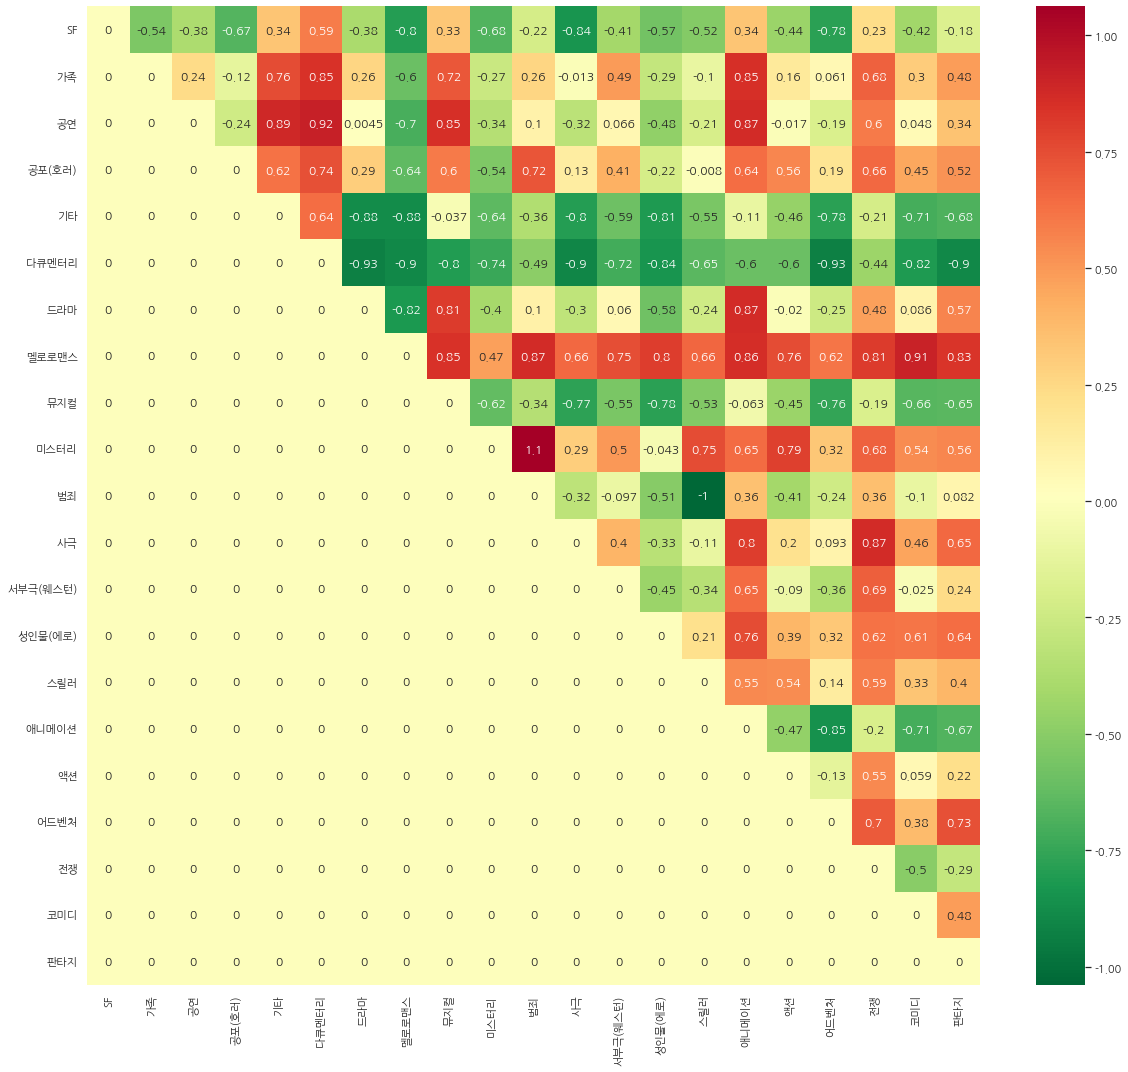

In [79]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.figure(figsize=(20, 18))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
plt.show()

In [80]:
# WEAT 스코어 절대값이 0.8 이상인 경우만 출력
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if abs(matrix[i][j]) >= 0.8:  # 절대값 0.8 이상만 출력
            print(f"{genre_name[i]}  {genre_name[j]}  {matrix[i][j]:.2f}")

SF  사극  -0.84
가족  다큐멘터리  0.85
가족  애니메이션  0.85
공연  기타  0.89
공연  다큐멘터리  0.92
공연  뮤지컬  0.85
공연  애니메이션  0.87
기타  드라마  -0.88
기타  멜로로맨스  -0.88
기타  성인물(에로)  -0.81
다큐멘터리  드라마  -0.93
다큐멘터리  멜로로맨스  -0.90
다큐멘터리  뮤지컬  -0.80
다큐멘터리  사극  -0.90
다큐멘터리  성인물(에로)  -0.84
다큐멘터리  어드벤처  -0.93
다큐멘터리  코미디  -0.82
다큐멘터리  판타지  -0.90
드라마  멜로로맨스  -0.82
드라마  뮤지컬  0.81
드라마  애니메이션  0.87
멜로로맨스  뮤지컬  0.85
멜로로맨스  범죄  0.87
멜로로맨스  성인물(에로)  0.80
멜로로맨스  애니메이션  0.86
멜로로맨스  전쟁  0.81
멜로로맨스  코미디  0.91
멜로로맨스  판타지  0.83
미스터리  범죄  1.06
범죄  스릴러  -1.04
사극  애니메이션  0.80
사극  전쟁  0.87
애니메이션  어드벤처  -0.85


Word2Vec으로 유사성 제거한 예술,일반 단어집합 WEAT 스코어

In [81]:
target_art_0_8

['음악',
 '결심',
 '운명',
 '지금',
 '여인',
 '이름',
 '이후',
 '준비',
 '감정',
 '만난',
 '처음',
 '충격',
 '누구',
 '그린',
 '연인']

In [82]:
target_gen_0_8

['서울',
 '애니메이션',
 '여성',
 '가지',
 '주인공',
 '대해',
 '연출',
 '사회',
 '섹스',
 '바로',
 '의도',
 '계획',
 '정체',
 '한국']

In [83]:
X = np.array([model.wv[word] for word in target_art_0_8])
Y = np.array([model.wv[word] for word in target_gen_0_8])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [84]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.5101407
SF 공연 -0.5489839
SF 공포(호러) -0.5581872
SF 기타 0.1194245
SF 다큐멘터리 0.4311026
SF 드라마 -0.3994223
SF 멜로로맨스 -0.7085699
SF 뮤지컬 0.07687606
SF 미스터리 -0.57276285
SF 범죄 -0.21556793
SF 사극 -0.85357004
SF 서부극(웨스턴) -0.41431627
SF 성인물(에로) -0.54789335
SF 스릴러 -0.43544087
SF 애니메이션 0.1937102
SF 액션 -0.38445872
SF 어드벤처 -0.65930104
SF 전쟁 -0.08844643
SF 코미디 -0.41355497
SF 판타지 -0.20688838
가족 공연 -0.23774551
가족 공포(호러) -0.049053807
가족 기타 0.6154062
가족 다큐멘터리 0.7610371
가족 드라마 0.0961407
가족 멜로로맨스 -0.6221859
가족 뮤지컬 0.5320378
가족 미스터리 -0.20874113
가족 범죄 0.1994581
가족 사극 -0.3328588
가족 서부극(웨스턴) 0.37290406
가족 성인물(에로) -0.3982559
가족 스릴러 -0.0698879
가족 애니메이션 0.7477656
가족 액션 0.13935252
가족 어드벤처 0.10419447
가족 전쟁 0.4860009
가족 코미디 0.20874213
가족 판타지 0.43686563
공연 공포(호러) 0.07389726
공연 기타 0.820485
공연 다큐멘터리 0.86953235
공연 드라마 0.348452
공연 멜로로맨스 -0.5504208
공연 뮤지컬 0.7528758
공연 미스터리 -0.07634486
공연 범죄 0.259263
공연 사극 -0.11660706
공연 서부극(웨스턴) 0.40076533
공연 성인물(에로) -0.3425396
공연 스릴러 0.035499778
공연 애니메이션 0.88313794
공연 액션 0.21484336
공연 

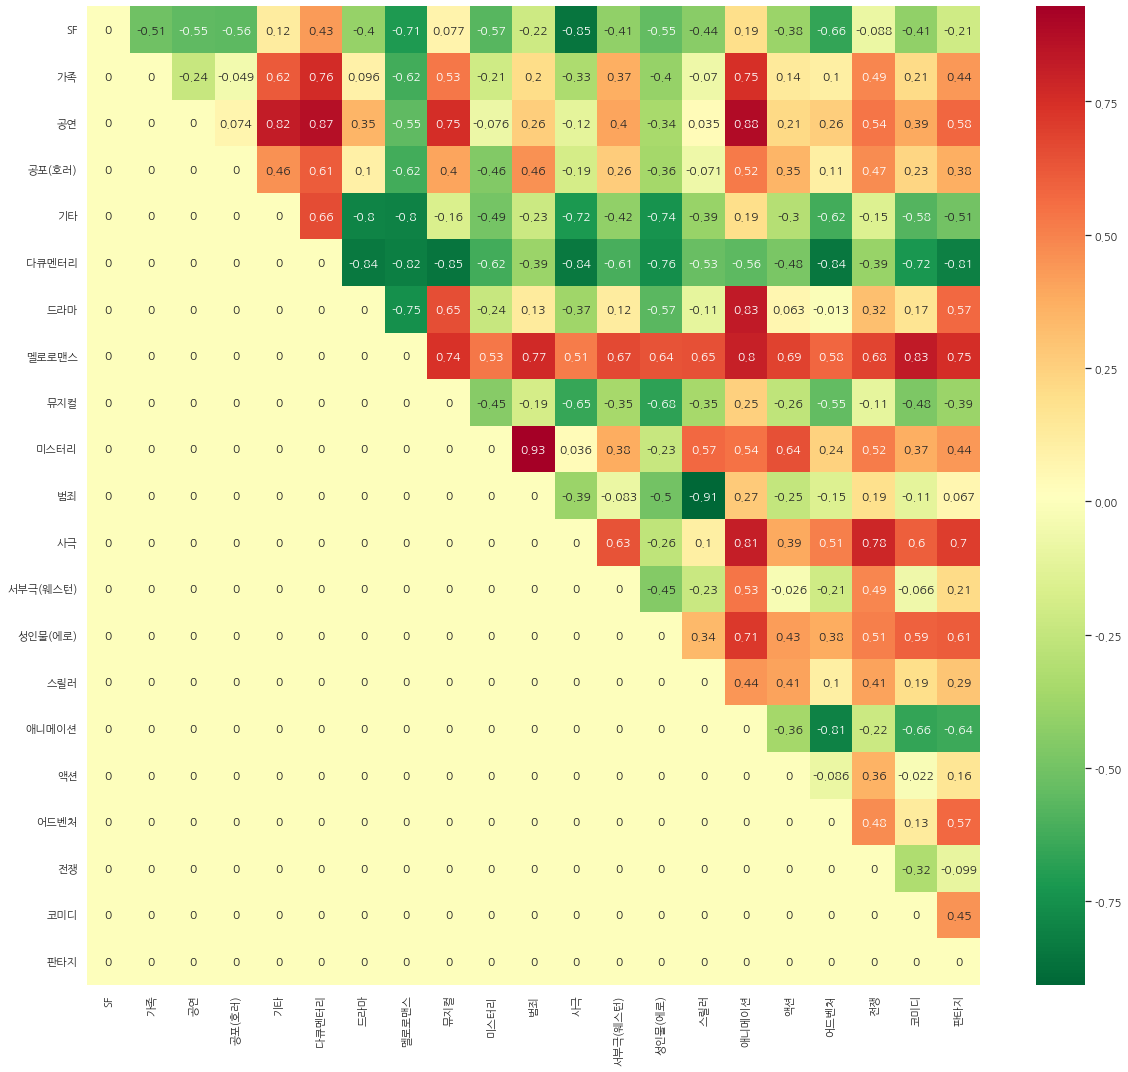

In [85]:
plt.figure(figsize=(20, 18))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
plt.show()

In [86]:
# WEAT 스코어 절대값이 0.8 이상인 경우만 출력
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if abs(matrix[i][j]) >= 0.8:  # 절대값 0.8 이상만 출력
            print(f"{genre_name[i]}  {genre_name[j]}  {matrix[i][j]:.2f}")

SF  사극  -0.85
공연  기타  0.82
공연  다큐멘터리  0.87
공연  애니메이션  0.88
기타  멜로로맨스  -0.80
다큐멘터리  드라마  -0.84
다큐멘터리  멜로로맨스  -0.82
다큐멘터리  뮤지컬  -0.85
다큐멘터리  사극  -0.84
다큐멘터리  어드벤처  -0.84
다큐멘터리  판타지  -0.81
드라마  애니메이션  0.83
멜로로맨스  애니메이션  0.80
멜로로맨스  코미디  0.83
미스터리  범죄  0.93
범죄  스릴러  -0.91
사극  애니메이션  0.81
애니메이션  어드벤처  -0.81


- 기본단어셋
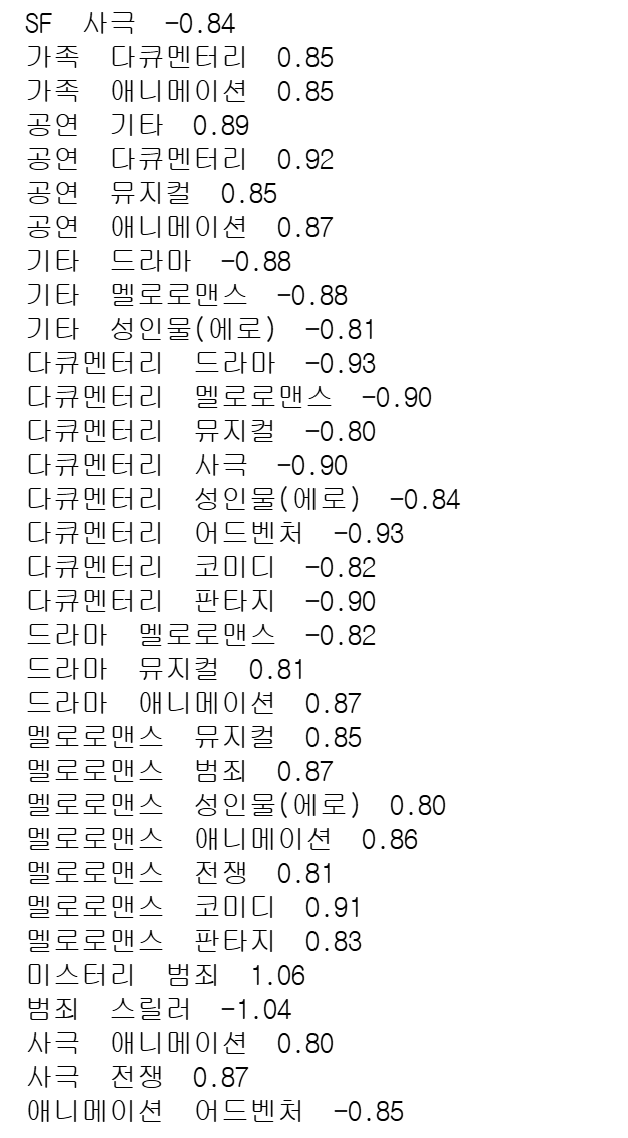

- 유사성>0.8 필터링 단어셋
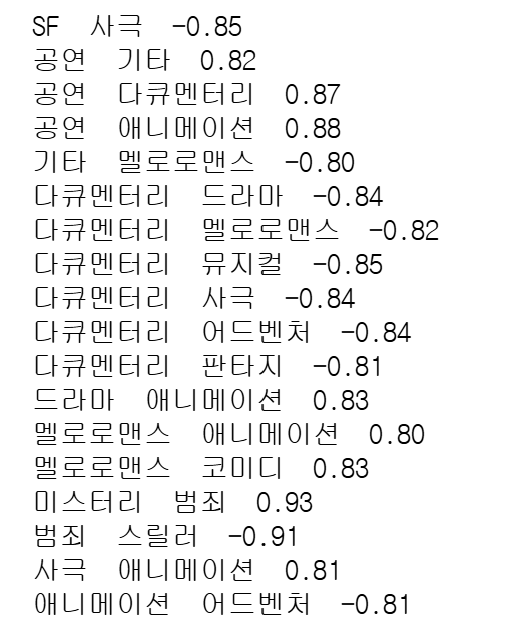